# Entrenando word vectors desde un corpus plano

In [2]:
# import re

with open('hp1.txt','r') as file:
    corpus = file.read()
    corpus = re.sub(r'\n+\d+\n+\x0c',r'\n',corpus)
    corpus = re.sub(r'\n+\d+\n+\b',r'\n\n',corpus)
    corpus = re.sub(r'\b\n\b',' ', corpus)
    corpus = re.sub(r',\n\b',', ', corpus)
    corpus = re.sub(r'\b\n+\b',r'. ',corpus)
    corpus = re.sub(r'^\n+',r'',corpus)
    corpus = re.sub(r'—',r'-',corpus)
    corpus = re.sub(r'»',r'"',corpus)
    corpus = re.sub(r'«',r'"',corpus)
    with open('hp1_v2.txt','w') as file2:
        file2.write(corpus)

import re

with open('hp1_v2.txt','r') as file:
    corpus = file.read()
    
def tokenize(corpus):
    paragraphs = re.findall(r'.+\n',corpus)
    return [re.findall(r'\b[\w\-,"]+\b', par) for par in paragraphs]
    
corpus = tokenize(corpus)



In [1]:
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
import torch.optim as optim


class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self):

        self._token_to_idx = {}
        self._idx_to_token = {}
        self._idx_to_freq = {}

    def add_token(self, token):
        
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
            self._idx_to_freq[index] += 1
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
            self._idx_to_freq[index] = 1
        return index
    
    def index_to_token(self, index):
        
        if not isinstance(index, list):
            if not isinstance(index, int):
                raise NameError("'index' must be an integer or list of integers")
            if index not in self._idx_to_token:
                raise KeyError('the index {} exeeds the Vocabulary lenght'.format(index))
            return self._idx_to_token[index]
        
        tokens = []
        for idx in index:
            if not isinstance(idx, int):
                raise NameError("{} is not an integer".format(idx))
            if idx not in self._idx_to_token:
                raise KeyError('the index {} exeeds the Vocabulary lenght'.format(idx))
            tokens.append(self._idx_to_token[idx])
        return tokens

    def token_to_index(self, token):
        
        if not isinstance(token, list):
            if not isinstance(token, str):
                raise NameError("'token' must be a string or list of strings")
            if token not in self._token_to_idx:
                raise KeyError('the token {} is not in the Vocabulary'.format(token))
            return self._token_to_idx[token]
        
        indeces = []
        for tk in token:
            if not isinstance(tk, str):
                raise NameError("'token' must be a string or list of strings")
            if tk not in self._token_to_idx:
                raise KeyError('the token {} is not in the Vocabulary'.format(tk))
            indeces.append(self._token_to_idx[tk])
        return indeces
    
    def get_freq(self, tk_or_idx):
        
        if isinstance(tk_or_idx, int):
            if tk_or_idx not in self._idx_to_token:
                raise KeyError('the index {} exeeds the Vocabulary lenght'.format(tk_or_idx))
            freq = self._idx_to_freq[tk_or_idx]
        elif isinstance(tk_or_idx, str):
            if tk_or_idx not in self._token_to_idx:
                freq = 0
            else:
                freq = self._idx_to_freq[self._token_to_idx[tk_or_idx]]
        else:
            raise KeyError('{} must be either integer or string'.format(tk_or_idx))
        
        return freq

    def __str__(self):
        return "<Vocabulary(size={})>".format(len(self))

    def __len__(self):
        return len(self._token_to_idx)


def tokenize(corpus):
    paragraphs = re.findall(r'.+\n',corpus)
    return [re.findall(r'\b[\w\-,"]+\b', par) for par in paragraphs]


class Word2VecSamples(Dataset):
    
    no_token = '<NT>'
    
    def __init__(self, corpus, window_size=2):
        
        # Obtengo el vocabulario a partir del corpus ya tokenizado:
        self.corpus = corpus
        self.vocabulary = Vocabulary()
        for doc in corpus:
            for token in doc:
                self.vocabulary.add_token(token)
                
        # Obtengo el contexto a partir del corpus:
        self.window_size = window_size
        self.data = pd.DataFrame({'word': [token for doc in corpus for token in doc],
                                  'context': [[self.no_token for j in range(i-window_size, max(0,i-window_size))] + \
                                              doc[max(0,i-window_size):i] + \
                                              doc[i+1:min(i+window_size+1, len(doc))] + \
                                              [self.no_token for j in range(min(i+window_size+1, len(doc)),i+window_size+1)] \
                                              for doc in corpus for i in range(len(doc))]
                                 })
        self.padding_idx = len(self.vocabulary)
        
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        word_vector = torch.tensor(self.vocabulary.token_to_index(self.data['word'].iloc[idx]), dtype=torch.long)
        context_vector = torch.zeros(2 * self.window_size, dtype=torch.long)
        for i, token in enumerate(self.data['context'].iloc[idx]):
            if token == self.no_token:
                context_vector[i] = self.padding_idx
            else:
                context_vector[i] = self.vocabulary.token_to_index(token)
            
        return word_vector, context_vector        
    
    def __len__(self):
        return len(self.data)
        
        
class CBOWModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel,self).__init__()
        self.emb = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=vocab_size)
        self.out = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self,x):
        embedding = self.emb(x).mean(dim=1)
        return self.out(embedding)
    
    def loss(self,scores,target):
        lf = nn.CrossEntropyLoss()
        return lf(scores,target)
        
        
class SkipGramModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel,self).__init__()
        self.emb = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=vocab_size)
        self.out = nn.Linear(embedding_dim, vocab_size)
        self.vocab_size = vocab_size
        
    def forward(self,x):
        return self.out(self.emb(x))
    
    def loss(self,scores,target):
        lf = nn.CrossEntropyLoss(ignore_index=self.vocab_size)
        if target.size() != torch.Size([2]):
            context_size = target.size(1)
            scores = scores.view(-1,self.vocab_size,1).repeat(1,1,context_size)
        return lf(scores,target)


def TrainWordVectors(data, 
                     lm='CBOW', 
                     window_size=2,
                     batch_size=64,
                     embedding_dim=100,
                     use_gpu=True,
                     epochs=1,
                     learning_rate=1e-2,
                     sample_loss_every=100):
    
    # Chequeo que se haya pasado bien el corpus:
    if isinstance(data,str):
        corpus = tokenize(data)
    elif isinstance(data,list):
        for doc in data:
            if isinstance(doc,list):
                for token in doc:
                    if isinstance(token,str):
                        corpus = data
    else:
        raise TypeError('data debe ser una lista de listas de tokens o un texto plano (string)')
        return
    
    
    # Obtengo los batches de muestras:
    dataset = Word2VecSamples(corpus, window_size=window_size)
    samples_idx = torch.randperm(len(dataset))
    my_sampler = lambda indices: sampler.SubsetRandomSampler(indices)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=my_sampler(samples_idx))
    
    vocab_size = len(dataset.vocabulary)    
    
    # Defino el modelo:
    if lm == 'CBOW':
        model = CBOWModel(vocab_size, embedding_dim)
    elif lm == 'SkipGram':
        model = SkipGramModel(vocab_size, embedding_dim)
    else:
        raise TypeError('El modelo de entrenamiento no es válido.')
    
    
    print('Starting training...')
    performance_history = {'iter': [], 'loss': [], 'accuracy': []}
    device = torch.device('cuda:0') if torch.cuda.is_available() and use_gpu else torch.device('cpu')
    model = model.to(device=device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    batch_len = len(dataloader)
    
    try:
        for e in range(epochs):
            for t, (x,y) in enumerate(dataloader):
                model.train()
                x = x.to(device=device, dtype=torch.long)
                y = y.to(device=device, dtype=torch.long)

                if lm == 'CBOW':
                    scores = model(y)
                    loss = model.loss(scores,x)
                elif lm == 'SkipGram':
                    scores = model(x)
                    loss = model.loss(scores,y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (e * batch_len + t) % sample_loss_every == 0:
                    performance_history['iter'].append(e * batch_len + t)
                    performance_history['loss'].append(loss.item())
                    print('Epoch: {}, Batch number: {}, Loss: {}'.format(e+1, t,loss.item()))
                    
        return performance_history
                    
    except KeyboardInterrupt:
        
        print('Exiting training...')
        return performance_history

In [20]:
with open('hp1_v2.txt','r') as file:
    corpus = file.read()
    
performance_history_sk = TrainWordVectors(corpus,
                                       lm='SkipGram', 
                                       window_size=2,
                                       batch_size=64,
                                       embedding_dim=100,
                                       use_gpu=True,
                                       epochs=10,
                                       learning_rate=1e-2,
                                       sample_loss_every=200)

performance_history_cbow = TrainWordVectors(corpus,
                                       lm='CBOW', 
                                       window_size=2,
                                       batch_size=64,
                                       embedding_dim=100,
                                       use_gpu=True,
                                       epochs=10,
                                       learning_rate=1e-2,
                                       sample_loss_every=200)


Starting training...
Epoch: 1, Batch number: 0, Loss: 9.265244483947754
Epoch: 1, Batch number: 200, Loss: 9.220480918884277
Epoch: 1, Batch number: 400, Loss: 9.213553428649902
Epoch: 1, Batch number: 600, Loss: 9.161966323852539
Epoch: 1, Batch number: 800, Loss: 9.196440696716309
Epoch: 1, Batch number: 1000, Loss: 9.104074478149414
Epoch: 1, Batch number: 1200, Loss: 9.146220207214355
Epoch: 2, Batch number: 185, Loss: 9.02599811553955
Epoch: 2, Batch number: 385, Loss: 8.983983039855957
Epoch: 2, Batch number: 585, Loss: 9.067724227905273
Epoch: 2, Batch number: 785, Loss: 8.981515884399414
Epoch: 2, Batch number: 985, Loss: 8.908655166625977
Epoch: 2, Batch number: 1185, Loss: 8.915628433227539
Epoch: 3, Batch number: 170, Loss: 8.946621894836426
Epoch: 3, Batch number: 370, Loss: 8.91558837890625
Epoch: 3, Batch number: 570, Loss: 8.943169593811035
Epoch: 3, Batch number: 770, Loss: 8.847766876220703
Epoch: 3, Batch number: 970, Loss: 8.829195976257324
Epoch: 3, Batch number: 11

<IPython.core.display.Javascript object>


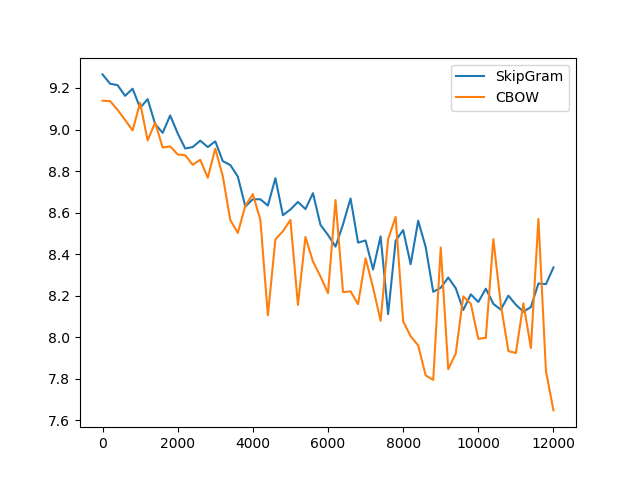

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(performance_history_sk['iter'],performance_history_sk['loss'],label='SkipGram')
ax.plot(performance_history_cbow['iter'],performance_history_cbow['loss'],label='CBOW')
ax.legend()

In [76]:
from torch.utils.data import Dataset
import torch.nn as nn


class Word2VecSamples(Dataset):
    
    no_token = '<NT>'
    
    def __init__(self, corpus, window_size=2):
        
        # Obtengo el vocabulario a partir del corpus ya tokenizado:
        self.corpus = corpus
        self.vocabulary = Vocabulary()
        for doc in corpus:
            for token in doc:
                self.vocabulary.add_token(token)
                
        # Obtengo el contexto a partir del corpus:
        self.window_size = window_size
        self.data = pd.DataFrame({'word': [token for doc in corpus for token in doc],
                                  'context': [[self.no_token for j in range(i-window_size, max(0,i-window_size))] + \
                                              doc[max(0,i-window_size):i] + \
                                              doc[i+1:min(i+window_size+1, len(doc))] + \
                                              [self.no_token for j in range(min(i+window_size+1, len(doc)),i+window_size+1)] \
                                              for doc in corpus for i in range(len(doc))]
                                 })
        self.padding_idx = len(self.vocabulary)
        
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        word_vector = torch.tensor(self.vocabulary.token_to_index(self.data['word'].iloc[idx]), dtype=torch.long)
        context_vector = torch.zeros(2 * self.window_size, dtype=torch.long)
        for i, token in enumerate(self.data['context'].iloc[idx]):
            if token == self.no_token:
                context_vector[i] = self.padding_idx
            else:
                context_vector[i] = self.vocabulary.token_to_index(token)
            
        return word_vector, context_vector        
        
        
class CBOWModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel,self).__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size)
        self.out = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self,x):
        return self.out(self.emb(x))
    
    def loss(self,scores,target):
        lf = nn.CrossEntropyLoss()
        return lf(scores,target)
        
        
class SkipGramModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel,self).__init__()
        self.emb = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=vocab_size)
        self.out = nn.Linear(embedding_dim, vocab_size)
        self.vocab_size = vocab_size
        
    def forward(self,x):
        return self.out(self.emb(x))
    
    def loss(self,scores,target):
        lf = nn.CrossEntropyLoss()
        if target.size() != torch.Size([2]):
            context_size = target.size(1)
            scores = scores.view(-1,self.vocab_size,1).repeat(1,1,context_size)
            print(scores)
            print(target)
        return lf(scores,target)

SkipGramModel(
  (emb): Embedding(101, 100, padding_idx=100)
  (out): Linear(in_features=100, out_features=100, bias=True)
)

Defino el modelo

In [78]:
from TorchDataUtils import *

def tokenizer(token_series):
    return token_series.split(' ')


# FALTA HACER UNA FUNCIÓN TrainWord2Vec(..., model='SkipGram') QUE NO SIGA EL FORMATO DE UN PROBLEMA
# DE CLASIFICACIÓN COMÚN.
corpus = ['El niño que vivió','El señor y la señora Dursley, que vivían en el número 4 de Privet Drive, estaban orgullosos de decir que eran muy normales, afortunadamente. Eran las últimas personas que se esperaría encontrar relacionadas con algo extraño o misterioso, porque no estaban para tales tonterías.','El señor Dursley era el director de una empresa llamada Grunnings, que fabricaba taladros. Era un hombre corpulento y rollizo, casi sin cuello, aunque con un bigote inmenso. La señora Dursley era delgada, rubia y tenía un cuello casi el doble de largo de lo habitual, lo que le resultaba muy útil, ya que pasaba la mayor parte del tiempo estirándolo por encima de la valla de los jardines para espiar a sus vecinos. Los Dursley tenían un hijo pequeño llamado Dudley, y para ellos no había un niño mejor que él.']
corpus = [tokenizer(par) for par in corpus]
dataset = Word2VecSamples(corpus, window_size=2)
vocab_size = len(samples.vocabulary)
embedding_dim = 100
model = SkipGramModel(vocab_size, embedding_dim)

NameError: name 'train_dataset' is not defined